# Import libraries and Data loading
1. Run first cell first
2. Upload kaggle.json to left the panel in Colab (get it from kaggle Profile -> Account -> API -> Create New API Token)
3. Then run the rest of the notebook


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler

tf.__version__

'2.9.1'

In [2]:
!pip install tensorflow_decision_forests 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
import tensorflow_decision_forests as tfdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download patelris/crop-yield-prediction-dataset
!unzip crop-yield-prediction-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  0% 0.00/959k [00:00<?, ?B/s]
100% 959k/959k [00:00<00:00, 19.7MB/s]
Archive:  crop-yield-prediction-dataset.zip
  inflating: pesticides.csv          
  inflating: rainfall.csv            
  inflating: temp.csv                
  inflating: yield.csv               
  inflating: yield_df.csv            


# Data exploration and preprocessing

In [4]:
df = pd.read_csv('yield_df.csv', index_col=0)
df

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [5]:
# rename columns
df = df.rename(columns={'Area': 'country', 'Item': 'item', 'Year': 'year', 
                        'average_rain_fall_mm_per_year': 'avg_rainfall', 
                        'pesticides_tonnes': 'pest_tonnes'})
df

,country,item,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [6]:
df.head()

,country,item,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [7]:
# check for null values in df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       28242 non-null  object 
 1   item          28242 non-null  object 
 2   year          28242 non-null  int64  
 3   hg/ha_yield   28242 non-null  int64  
 4   avg_rainfall  28242 non-null  float64
 5   pest_tonnes   28242 non-null  float64
 6   avg_temp      28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [8]:
# see countries
df['country'].value_counts()

India         4048
Brazil        2277
Mexico        1472
Pakistan      1449
Japan          966
              ... 
Estonia         42
Belgium         39
Bahrain         29
Sudan           28
Montenegro      24
Name: country, Length: 101, dtype: int64

In [9]:
# see harvest items
df['item'].value_counts()

Potatoes                4276
Maize                   4121
Wheat                   3857
Rice, paddy             3388
Soybeans                3223
Sorghum                 3039
Sweet potatoes          2890
Cassava                 2045
Yams                     847
Plantains and others     556
Name: item, dtype: int64

In [10]:
# see data distribution
df.describe()

,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
count,28242.000000,28242.000000,28242.00000,28242.000000,28242.000000
mean,2001.544296,77053.332094,1149.05598,37076.909344,20.542627
std,7.051905,84956.612897,709.81215,59958.784665,6.312051
min,1990.000000,50.000000,51.00000,0.040000,1.300000
25%,1995.000000,19919.250000,593.00000,1702.000000,16.702500
50%,2001.000000,38295.000000,1083.00000,17529.440000,21.510000
75%,2008.000000,104676.750000,1668.00000,48687.880000,26.000000
max,2013.000000,501412.000000,3240.00000,367778.000000,30.650000


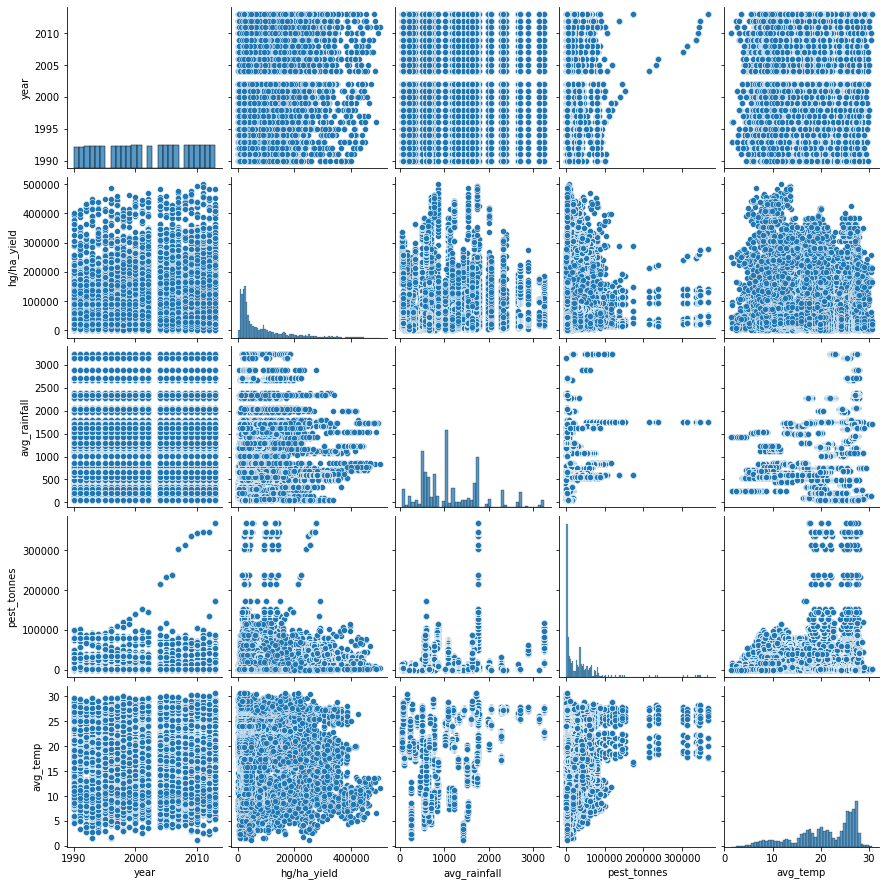

In [11]:
# # visualize data from columns
sns.pairplot(df.select_dtypes(include=['int64', 'float64']))

In [12]:
# Select columns with numerical values
set(df.dtypes.tolist())

{dtype('int64'), dtype('float64'), dtype('O')}

In [13]:
df_num = df.select_dtypes(include=['int64','float64'])
df_num.head()

,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
0,1990,36613,1485.0,121.0,16.37
1,1990,66667,1485.0,121.0,16.37
2,1990,23333,1485.0,121.0,16.37
3,1990,12500,1485.0,121.0,16.37
4,1990,7000,1485.0,121.0,16.37


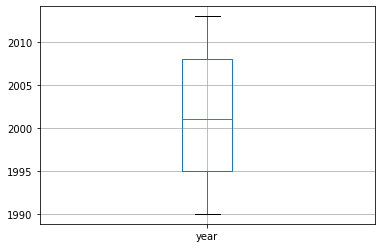

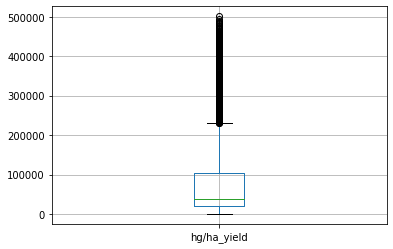

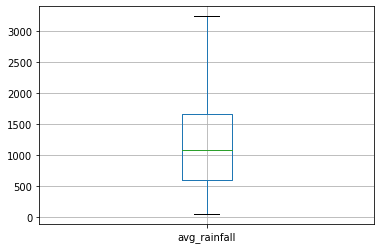

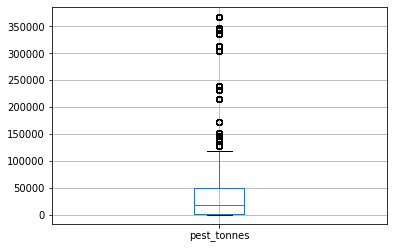

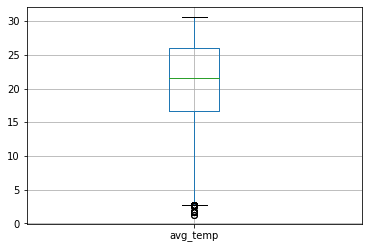

In [14]:
# OUTLIER REMOVAL
# visualize data before outlier cleaning
for column in df_num.columns.tolist():
  df.boxplot(column=column)
  plt.show()

In [16]:
# initialize outlier removal function
def drop_outliers(df, column_names):
  for column_name in column_names:
    # print(column_name, end=' ')
    iqr = 1.5 * (np.percentile(df[column_name], 75) - np.percentile(df[column_name], 25))
    df.drop(df[df[column_name] > (iqr + np.percentile(df[column_name], 75))].index, inplace=True)
    df.drop(df[df[column_name] < (np.percentile(df[column_name], 25) - iqr)].index, inplace=True)

    df.reset_index()

# drop outliers
drop_outliers(df, df_num.columns.tolist())
drop_outliers(df, df_num.columns.tolist())

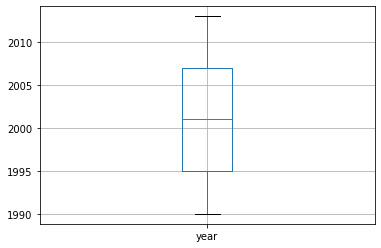

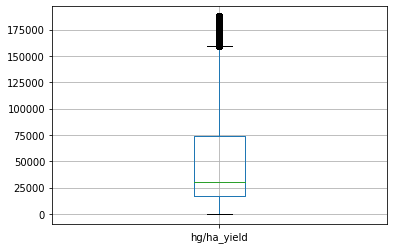

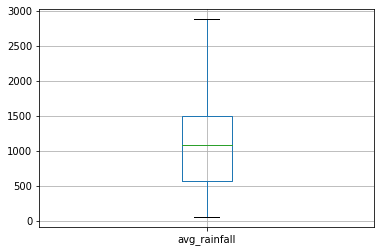

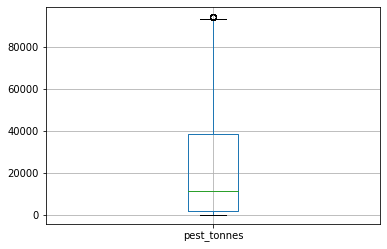

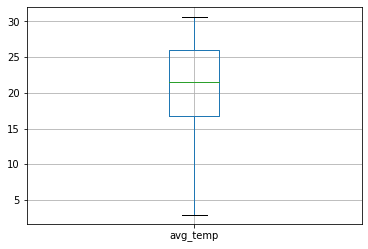

In [17]:
# visualize data after outlier
for column_name in df_num.columns.tolist():
  df.boxplot(column=column_name)
  plt.show()

In [18]:
# +- 6,000 data were outlier 
df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22685 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       22685 non-null  object 
 1   item          22685 non-null  object 
 2   year          22685 non-null  int64  
 3   hg/ha_yield   22685 non-null  int64  
 4   avg_rainfall  22685 non-null  float64
 5   pest_tonnes   22685 non-null  float64
 6   avg_temp      22685 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.9+ MB


In [19]:
# find correlation coeff of target variable with dependent variables
corr_matrix = df.corr()
corr_matrix['hg/ha_yield'].sort_values(ascending=False)

hg/ha_yield     1.000000
avg_rainfall    0.092390
year            0.013245
pest_tonnes     0.001622
avg_temp       -0.021585
Name: hg/ha_yield, dtype: float64

In [20]:
# see data types of each column
df.dtypes

country          object
item             object
year              int64
hg/ha_yield       int64
avg_rainfall    float64
pest_tonnes     float64
avg_temp        float64
dtype: object

In [21]:
# select numerical columns only
df.select_dtypes(include=['int64', 'float64'])

,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
0,1990,36613,1485.0,121.00,16.37
1,1990,66667,1485.0,121.00,16.37
2,1990,23333,1485.0,121.00,16.37
3,1990,12500,1485.0,121.00,16.37
4,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...
28237,2013,22581,657.0,2550.07,19.76
28238,2013,3066,657.0,2550.07,19.76
28239,2013,13142,657.0,2550.07,19.76
28240,2013,22222,657.0,2550.07,19.76


In [24]:
# initialize function to normalize 
# normalize data by using standard normalization
# which is data - mean of the observed columns then
# divide by standard deviation

def get_mean_and_std(df):
  
  num_cols = [col_name for col_name in df.select_dtypes(include=['int64', 'float64']) if col_name != 'year']

  # print('get_mean_and_std', num_cols)

  means = []
  std_devs = []

  for col in num_cols:
    means.append(df[col].mean())
    std_devs.append(df[col].std())

  # print('done getting mean and std', (means, std_devs))
  return means, std_devs

# initialize normalize function
def normalize(df, means, std_devs):

  num_cols = [col_name for col_name in df.select_dtypes(include=['int64', 'float64']) if col_name != 'year']

  for i, col in enumerate(num_cols):
    df[col] = df[col].apply(lambda x: (x - means[i]) / std_devs[i]) # https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c#:~:text=The%20data%20can%20be%20normalized,This%20results%20in%20faster%20convergence.

In [25]:
# normalize data
means, std_devs = get_mean_and_std(df)
normalize(df, means, std_devs)
df

,country,item,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
0,Albania,Maize,1990,-0.306663,0.615453,-0.903864,-0.659487
1,Albania,Potatoes,1990,0.351514,0.615453,-0.903864,-0.659487
2,Albania,"Rice, paddy",1990,-0.597493,0.615453,-0.903864,-0.659487
3,Albania,Sorghum,1990,-0.834734,0.615453,-0.903864,-0.659487
4,Albania,Soybeans,1990,-0.955183,0.615453,-0.903864,-0.659487
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,-0.613962,-0.629184,-0.805683,-0.127432
28238,Zimbabwe,Sorghum,2013,-1.041337,-0.629184,-0.805683,-0.127432
28239,Zimbabwe,Soybeans,2013,-0.820674,-0.629184,-0.805683,-0.127432
28240,Zimbabwe,Sweet potatoes,2013,-0.621824,-0.629184,-0.805683,-0.127432


In [26]:
# Create test set
from sklearn.model_selection import train_test_split

df.columns

Xs = ['avg_rainfall', 'pest_tonnes', 'avg_temp']
ys = ['hg/ha_yield']

# split between dependent and independent variables
df_feature = df[Xs]
df_target = df[ys]

# 80:20 data split
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_target, 
                                                    test_size=0.2, 
                                                    random_state=49)

X_train.shape, X_test.shape

((18148, 3), (4537, 3))

In [27]:
means, std_devs # hg/ha_yield, avg_rainfall, pest_tonnes, avg_temp
X_means, X_std_devs = means[1:], std_devs[1:]

# maintain the consistency of returning array of float
y_means, y_std_devs = means[0:1], std_devs[0:1]
y_means

[50616.0088163985]

In [28]:
df

,country,item,year,hg/ha_yield,avg_rainfall,pest_tonnes,avg_temp
0,Albania,Maize,1990,-0.306663,0.615453,-0.903864,-0.659487
1,Albania,Potatoes,1990,0.351514,0.615453,-0.903864,-0.659487
2,Albania,"Rice, paddy",1990,-0.597493,0.615453,-0.903864,-0.659487
3,Albania,Sorghum,1990,-0.834734,0.615453,-0.903864,-0.659487
4,Albania,Soybeans,1990,-0.955183,0.615453,-0.903864,-0.659487
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,-0.613962,-0.629184,-0.805683,-0.127432
28238,Zimbabwe,Sorghum,2013,-1.041337,-0.629184,-0.805683,-0.127432
28239,Zimbabwe,Soybeans,2013,-0.820674,-0.629184,-0.805683,-0.127432
28240,Zimbabwe,Sweet potatoes,2013,-0.621824,-0.629184,-0.805683,-0.127432


In [29]:
X_train[:5]
# X_train.shape (18148, 3)

,avg_rainfall,pest_tonnes,avg_temp
4,0.615453,-0.903864,-0.659487
9544,1.383580,-0.447188,-0.064652
23899,-0.659247,-0.636605,-1.403423
21887,-0.874203,-0.685723,0.586684
165,-1.482992,-0.757270,-0.500969


In [30]:
X_test[:5]

,avg_rainfall,pest_tonnes,avg_temp
1708,-0.814075,1.059164,-0.585721
26836,-0.725388,0.219543,-1.532120
19257,-0.477362,0.484447,0.702826
23441,0.995758,-0.495359,-0.557470
24005,0.205083,-0.898691,-0.124293


In [31]:
y_train[:5]

,hg/ha_yield
4,-0.955183
9544,0.351514
23899,-0.501046
21887,-0.672456
165,-0.827529


In [32]:
y_test[:5]

,hg/ha_yield
1708,-0.364764
26836,0.209713
19257,-0.176535
23441,1.619886
24005,-0.567578


In [33]:
# model building
def build_and_compile_model(X, y):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = 'mse',
                metrics=['mean_absolute_error'])
  
  history = model.fit(X, y, epochs=10, validation_split=0.2)
  
  return model, history

dnn_model, history = build_and_compile_model(X_train, y_train) # norm

Epoch 1/10
454/454 [==============================] - 2s 3ms/step - loss: 0.9888 - mean_absolute_error: 0.7967 - val_loss: 0.9110 - val_mean_absolute_error: 0.7695
Epoch 2/10
454/454 [==============================] - 1s 2ms/step - loss: 0.9750 - mean_absolute_error: 0.7886 - val_loss: 0.9073 - val_mean_absolute_error: 0.7620
Epoch 3/10
454/454 [==============================] - 1s 3ms/step - loss: 0.9709 - mean_absolute_error: 0.7849 - val_loss: 0.8947 - val_mean_absolute_error: 0.7475
Epoch 4/10
454/454 [==============================] - 1s 3ms/step - loss: 0.9696 - mean_absolute_error: 0.7834 - val_loss: 0.8984 - val_mean_absolute_error: 0.7544
Epoch 5/10
454/454 [==============================] - 2s 4ms/step - loss: 0.9649 - mean_absolute_error: 0.7826 - val_loss: 0.8882 - val_mean_absolute_error: 0.7364
Epoch 6/10
454/454 [==============================] - 2s 4ms/step - loss: 0.9640 - mean_absolute_error: 0.7820 - val_loss: 0.8891 - val_mean_absolute_error: 0.7160
Epoch 7/10
454/4

In [34]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [35]:
# model evaluation visualization
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error hg/ha_yield')
  plt.legend()
  plt.grid(True)

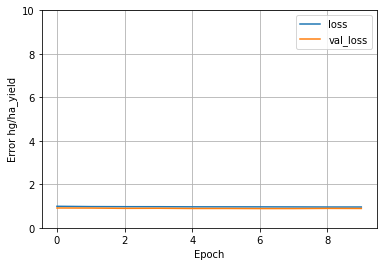

In [36]:
plot_loss(history)

In [37]:
# function to denormalize a dataframe
def denormalize(df, means, std_devs):  
  for i, col in enumerate(df.columns):
    df[col] = df[col].apply(lambda x: (x * std_devs[i]) + means[i])
    
  return df

In [38]:
X_means, X_std_devs 

([1075.5673793255455, 22483.32445272208, 20.571932113731574],
 [665.2545752543871, 24740.80176292232, 6.3715179737403185])

In [39]:
y_means, y_std_devs

([50616.0088163985], [45662.45987390438])

In [40]:
# denormalize data
Xs = [X_train, X_test]
ys = [y_train, y_test]

for df in Xs:
  denormalize(df, X_means, X_std_devs)

for df in ys:
  denormalize(df, y_means, y_std_devs)

In [41]:
X_train, X_test, y_train, y_test

(       avg_rainfall  pest_tonnes  avg_temp
 4            1485.0       121.00     16.37
 9544         1996.0     11419.53     20.16
 23899         637.0      6733.20     11.63
 21887         494.0      5518.00     24.31
 165            89.0      3747.86     17.38
 ...             ...          ...       ...
 10938        1083.0     70791.00     24.62
 24716         495.0     18025.00     15.77
 20492         346.0      9771.14     17.47
 27742        1300.0      2272.08     17.17
 454           591.0     30195.00     18.31
 
 [18148 rows x 3 columns],        avg_rainfall  pest_tonnes  avg_temp
 1708          534.0     48687.88     16.84
 26836         593.0     27915.00     10.81
 19257         758.0     34468.93     25.05
 23441        1738.0     10227.74     17.02
 24005        1212.0       249.00     19.78
 ...             ...          ...       ...
 17713         661.0      1816.00     19.65
 20723         346.0     13697.00     18.56
 2366         2666.0     15330.16     26.59
 105

In [42]:
# evaluate model
results = dnn_model.evaluate(X_test, y_test, verbose=0)
print("test loss, test acc:", results)

test loss, test acc: [4480504832.0, 49537.453125]


In [43]:
# compare model prediction with real value
print(denormalize(pd.DataFrame(dnn_model.predict(X_test[1:2])[0]), X_means, X_std_devs))
print('real value: {}'.format(y_test[1:2]))

1/1 [==============================] - 0s 155ms/step
               0
0  490356.542751
real value:        hg/ha_yield
26836      60192.0
